In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import pandas as pd

sns.set()
import numpy as np
import os
import glob
import sys
sys.path.append("..")
import hydra
from src.lib.config import register_configs
from src.models.LightningBaseModel import LightningModel
from src.utils.CustomMetrics import MultiLabelAccuracy
register_configs()
try:
    hydra.initialize(config_path="../conf", job_name="plankton")
except ValueError:
    print(ValueError)
    
import pytorch_lightning as pl
from natsort import natsorted
import pickle

In [2]:
# set global values:

experiments_multilabel = {
    "supervised_multilabel": "/gpfs/work/machnitz/plankton_logs/supervised/multilabel/multirun/2022-04-19/08-13-41",
    "linear_multilabel": "/gpfs/work/machnitz/plankton_logs/linear_eval/multilabel/multirun/2022-04-19/08-14-01",
    "finetune_multilabel": "/gpfs/work/machnitz/plankton_logs/finetune/multilabel/multirun/2022-04-19/08-14-27",
    "finetune_sgd_multilabel": "/gpfs/work/machnitz/plankton_logs/finetune_sgd/multilabel/multirun/2022-04-19/14-06-46"
}

experiments_singlelabel = {
    "supervised_singlelabel": "/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-04-19/08-14-50",
    "linear_singlelabel": "/gpfs/work/machnitz/plankton_logs/linear_eval/singlelabel/multirun/2022-04-19/19-15-20",
    "finetune_singlelabel": "/gpfs/work/machnitz/plankton_logs/finetune/singlelabel/multirun/2022-04-19/08-15-24",
    "finetune_sgd_singlelabel": "/gpfs/work/machnitz/plankton_logs/finetune_sgd/singlelabel/multirun/2022-04-19/08-15-10"
}

data_splits_per_experiment = [np.round(x,2) for x in np.arange(0.01, 0.1, 0.01)] + [np.round(x, 2) for x in np.arange(0.1, 1.1, 0.1)]
print("Data splits: ", data_splits_per_experiment)

Data splits:  [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [3]:
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()

hereon_color_array = np.array([
    [230, 0, 70],
    [0,145,160],
    [0, 170, 230],
    [250,180,35],
    [0,70,125],
    [175, 25, 60],
    [170, 200 ,70],
    [250,115,80],
    [140, 90, 180],
      
])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)

sns.set_palette(hereon_color_array)

# Multi Label experiments

We only need to load the config of the supervised run, since it only is used to init the data-loaders and they are the same for all single-label experiments.

In [4]:
pl.seed_everything(7)
np.random.seed(7)
cfg = hydra.compose(config_name="config", overrides=["+experiment=plankton/publication/supervised_multilabel", 
                                                     "random_seed=7", 
                                                     "strategy=SingleDevice", 
                                                     'strategy.device="cuda:0"', 
                                                     "trainer.enable_progress_bar=false",
                                                     "datamodule.batch_size=200"])

Global seed set to 7


In [5]:
train_transforms = hydra.utils.instantiate(cfg.datamodule.train_transforms)
valid_transforms = hydra.utils.instantiate(cfg.datamodule.valid_transforms)

datamodule = hydra.utils.instantiate(
    cfg.datamodule,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
    dataset=cfg.datamodule.dataset,
    is_ddp=False,
)
datamodule.setup(stage="test")

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:95: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


In [6]:
def get_confidence_and_acc(logits, labels, acc_func=MultiLabelAccuracy(weighted=True), n_bins=15):
    ece = torch.zeros(1, device=logits.device)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = torch.tensor([acc_func(predictions=prediction.unsqueeze(0), 
                                            targets=label.unsqueeze(0), 
                                            n_labels=labels.max()+1) 
                               for prediction, label in zip(predictions, labels)])
    accuracy_bins = []
    confidence_bins = []
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            accuracy_bins.append(accuracy_in_bin)
            confidence_bins.append(avg_confidence_in_bin)
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return torch.tensor(accuracy_bins), torch.tensor(confidence_bins), ece.item()


In [9]:
def instantiate_model(ckpt_path):
    model = LightningModel.load_from_checkpoint(checkpoint_path=ckpt_path)
    model.set_external_data(
        class_labels=datamodule.unique_labels,
        all_labels=datamodule.all_labels,
        example_input_array=example_input.detach().cpu(),
    )
    return model

def instantiate_trainer():
    trainer = hydra.utils.instantiate(
        cfg.trainer,
        strategy=cfg.strategy,
        logger=[],
        callbacks=[],
        _convert_="partial",
        profiler=None,
    )
    return trainer

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
Exception ignored in: <function _ConnectionBase.__del__ at 0x7f3ba0dbb670>
Traceback (most recent call last):
  File "/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


  0%|          | 0/19 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.17749999463558197    │
│       loss/Testing        │    2.8251943588256836     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4749999940395355     │
│       loss/Testing        │    2.2091434001922607     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4650000035762787     │
│       loss/Testing        │    1.6161805391311646     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.38499999046325684    │
│       loss/Testing        │     1.455483078956604     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.44999998807907104    │
│       loss/Testing        │    1.4184199571609497     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5324999690055847     │
│       loss/Testing        │    1.2952266931533813     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5550000071525574     │
│       loss/Testing        │     1.316196084022522     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5099999904632568     │
│       loss/Testing        │     1.297329306602478     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5199999809265137     │
│       loss/Testing        │    1.3041834831237793     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4699999988079071     │
│       loss/Testing        │    1.4901986122131348     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.48500001430511475    │
│       loss/Testing        │     1.365912675857544     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4699999988079071     │
│       loss/Testing        │    1.4370031356811523     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4699999988079071     │
│       loss/Testing        │    1.3171979188919067     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5475000143051147     │
│       loss/Testing        │    1.2774837017059326     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5049999952316284     │
│       loss/Testing        │     1.299687147140503     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.47749999165534973    │
│       loss/Testing        │    1.3113141059875488     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5349999666213989     │
│       loss/Testing        │    1.2889126539230347     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5475000143051147     │
│       loss/Testing        │    1.2263271808624268     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5475000143051147     │
│       loss/Testing        │    1.2496579885482788     │
└───────────────────────────┴───────────────────────────┘

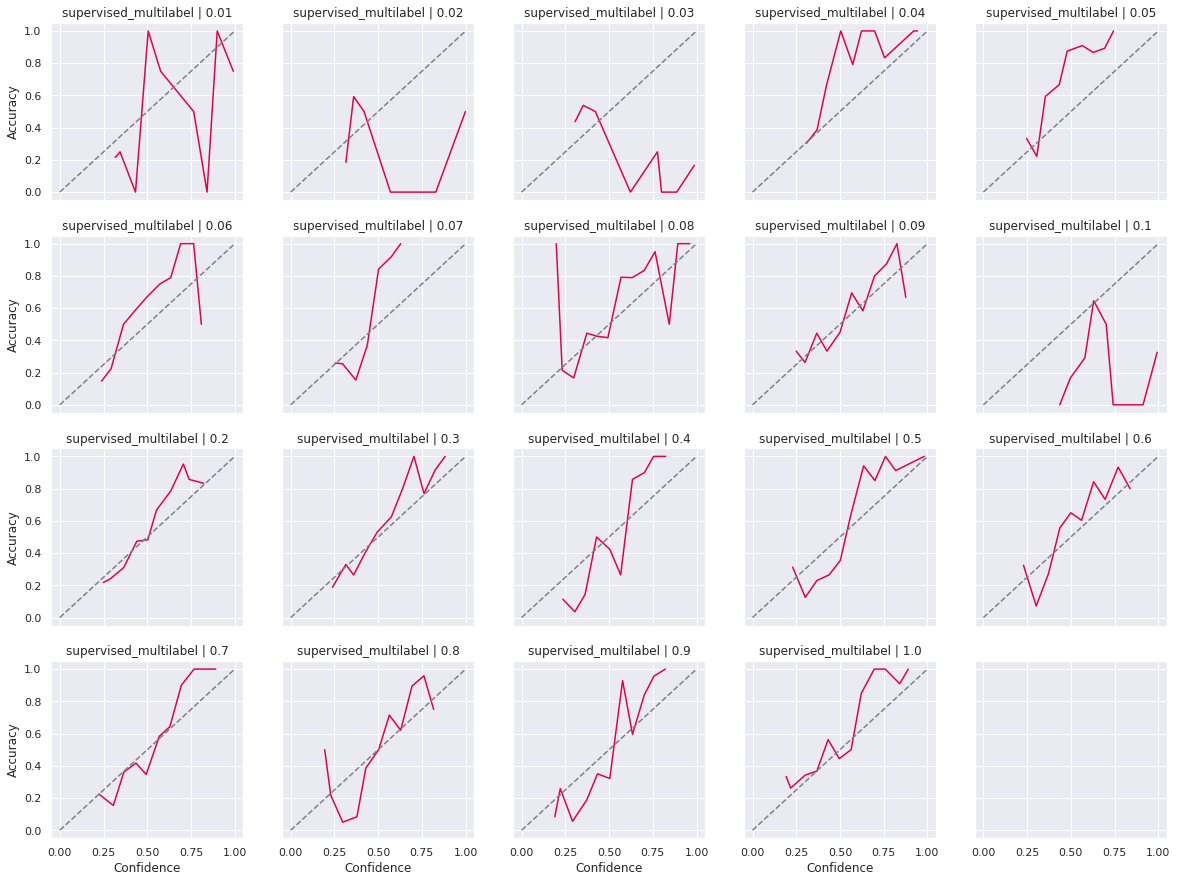

  0%|          | 0/19 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.1850000023841858     │
│       loss/Testing        │    1.8465607166290283     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5099999904632568     │
│       loss/Testing        │    1.5244321823120117     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4924999475479126     │
│       loss/Testing        │    1.4643347263336182     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5024999976158142     │
│       loss/Testing        │    1.2264065742492676     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │     0.512499988079071     │
│       loss/Testing        │     1.190900444984436     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6349999904632568     │
│       loss/Testing        │    1.0524184703826904     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6899999976158142     │
│       loss/Testing        │    0.8198292255401611     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6949999928474426     │
│       loss/Testing        │    0.8257519602775574     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7099999785423279     │
│       loss/Testing        │    0.8374999761581421     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7475000023841858     │
│       loss/Testing        │    0.8238409161567688     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7475000023841858     │
│       loss/Testing        │    0.6623734831809998     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7900000214576721     │
│       loss/Testing        │    0.5944664478302002     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8199999928474426     │
│       loss/Testing        │    0.5434027910232544     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │          0.8125           │
│       loss/Testing        │    0.5341920256614685     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7900000214576721     │
│       loss/Testing        │    0.5517359972000122     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8224999904632568     │
│       loss/Testing        │    0.5378339886665344     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │     0.824999988079071     │
│       loss/Testing        │    0.5369042158126831     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8149999976158142     │
│       loss/Testing        │    0.5349498391151428     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8174999952316284     │
│       loss/Testing        │    0.5445429086685181     │
└───────────────────────────┴───────────────────────────┘

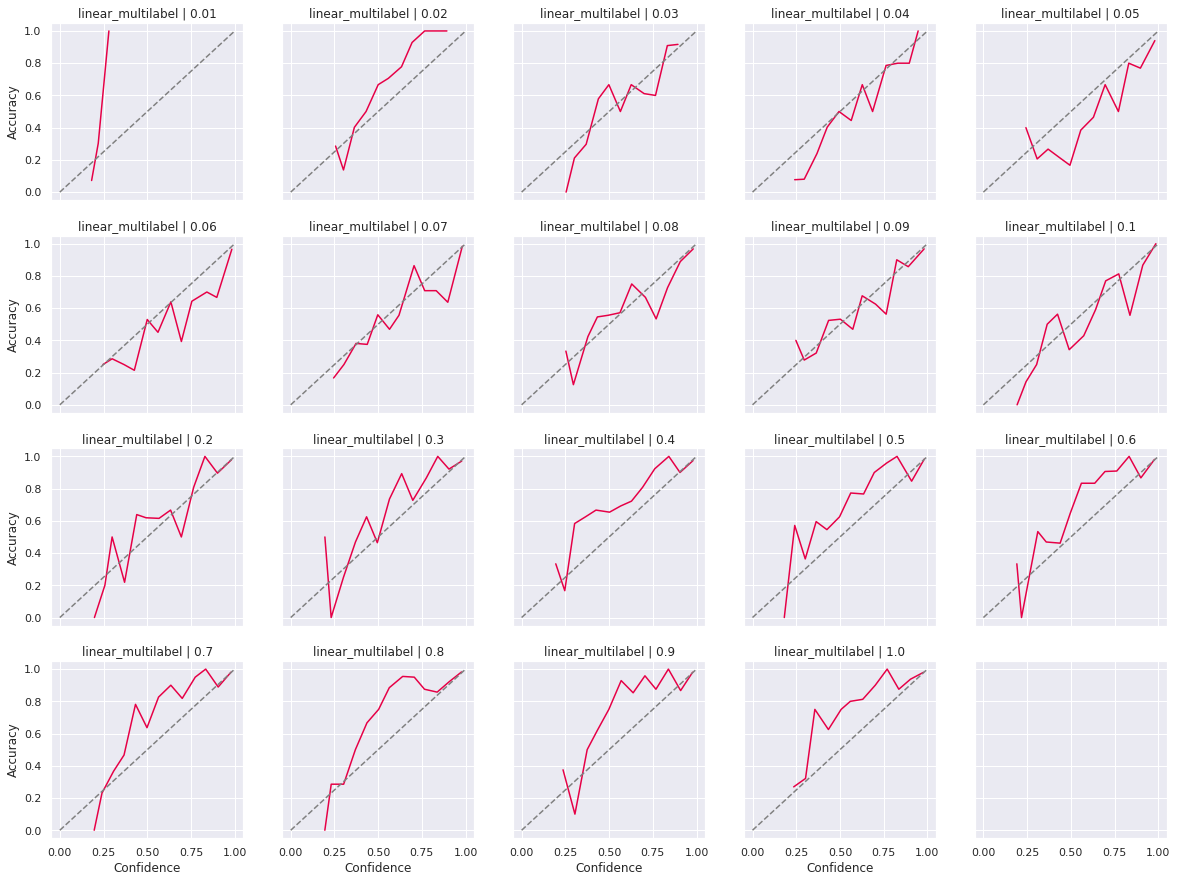

  0%|          | 0/19 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.13750000298023224    │
│       loss/Testing        │     2.679344415664673     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4949999749660492     │
│       loss/Testing        │     2.93588924407959      │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5724999904632568     │
│       loss/Testing        │    1.3620296716690063     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5874999761581421     │
│       loss/Testing        │     1.293154239654541     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5349999666213989     │
│       loss/Testing        │    1.2445740699768066     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5374999642372131     │
│       loss/Testing        │    1.3122799396514893     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5824999809265137     │
│       loss/Testing        │    1.2644188404083252     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │          0.5625           │
│       loss/Testing        │    1.0899972915649414     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5824999809265137     │
│       loss/Testing        │    1.1246908903121948     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5399999618530273     │
│       loss/Testing        │    1.2135010957717896     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5299999713897705     │
│       loss/Testing        │    1.1777288913726807     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5824999809265137     │
│       loss/Testing        │     1.143331527709961     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7099999785423279     │
│       loss/Testing        │    0.9363468885421753     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6625000238418579     │
│       loss/Testing        │     1.010257363319397     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6299999952316284     │
│       loss/Testing        │    0.9862053394317627     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5999999642372131     │
│       loss/Testing        │    1.0557124614715576     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5724999904632568     │
│       loss/Testing        │    1.0662301778793335     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5799999833106995     │
│       loss/Testing        │    0.9778544902801514     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6600000262260437     │
│       loss/Testing        │    0.9610252380371094     │
└───────────────────────────┴───────────────────────────┘

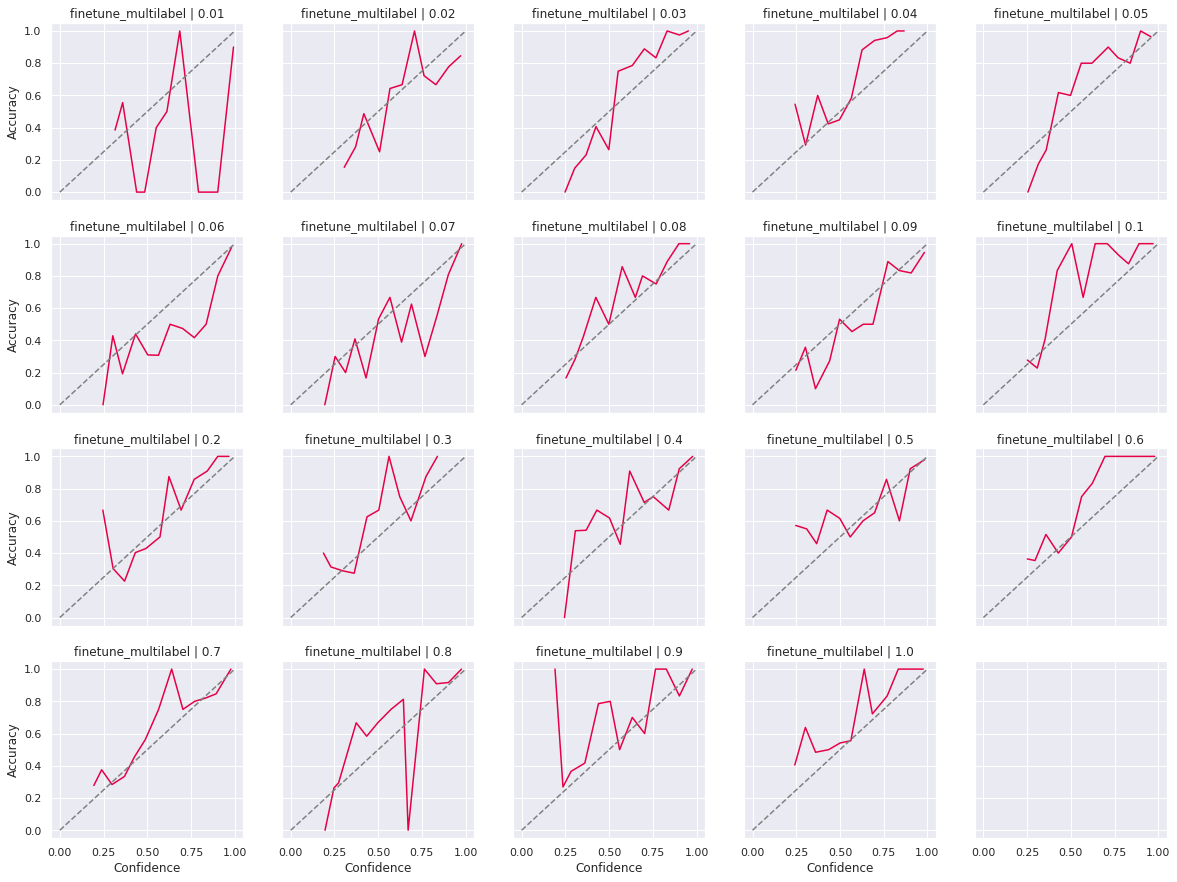

  0%|          | 0/19 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.19750000536441803    │
│       loss/Testing        │    1.8380769491195679     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5274999737739563     │
│       loss/Testing        │     1.544100284576416     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │     0.512499988079071     │
│       loss/Testing        │    1.4264224767684937     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5475000143051147     │
│       loss/Testing        │    1.1634670495986938     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5924999713897705     │
│       loss/Testing        │    1.0843604803085327     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7074999809265137     │
│       loss/Testing        │    0.9081857204437256     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7074999809265137     │
│       loss/Testing        │    0.8359697461128235     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8274999856948853     │
│       loss/Testing        │    1.0551594495773315     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7825000286102295     │
│       loss/Testing        │    0.8989417552947998     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6549999713897705     │
│       loss/Testing        │    1.0987671613693237     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7999999523162842     │
│       loss/Testing        │    0.6520361304283142     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8349999785423279     │
│       loss/Testing        │    0.5562930703163147     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8599998950958252     │
│       loss/Testing        │    0.5573160648345947     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8624999523162842     │
│       loss/Testing        │    0.4887147545814514     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8324999809265137     │
│       loss/Testing        │     0.618188738822937     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8450000286102295     │
│       loss/Testing        │    0.4570067524909973     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8599998950958252     │
│       loss/Testing        │    0.37826186418533325    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8849999904632568     │
│       loss/Testing        │    0.43571653962135315    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8700000047683716     │
│       loss/Testing        │    0.4636845290660858     │
└───────────────────────────┴───────────────────────────┘

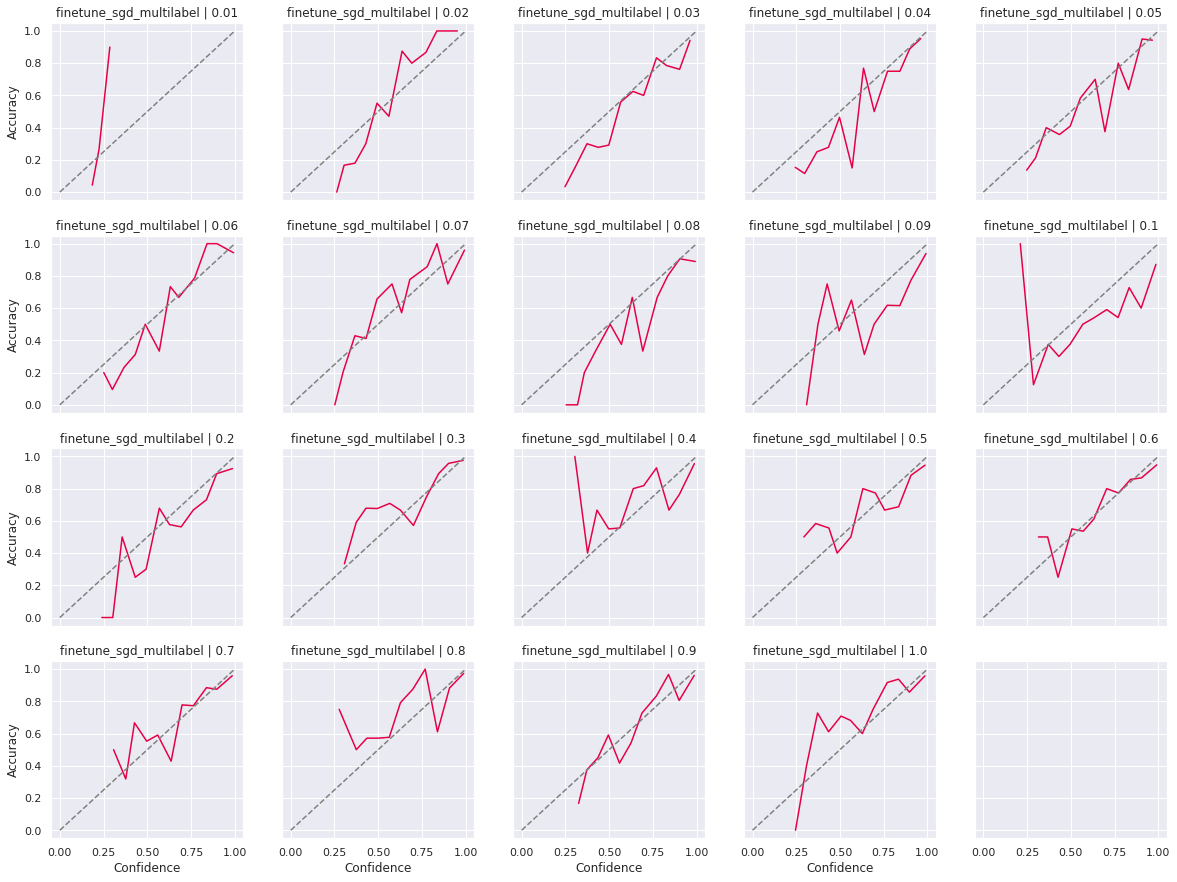

In [10]:
trainer = instantiate_trainer()

dataloader = datamodule.test_dataloader()

for batch in dataloader:
    example_input, _ = batch
    break
    
return_metrics = dict()
for key, setup_path in experiments_multilabel.items():
    experiment_folders = [os.path.join(setup_path, str(i)) for i in np.arange(0, 19)]
    return_metrics[key] = dict()
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20,15), sharex=True, sharey=True)
    for experiment_number, experiment_path in enumerate(tqdm(experiment_folders)):
        # print(experiment_number)
        with open(os.path.join(experiment_path, "main.log"), "r") as f:
            complete_log = f.readlines()
            found_best_checkpoint = False
            for line in complete_log:
                # print(line)
                if found_best_checkpoint:
                    best_checkpoint = line.strip()
                    # print(f"set best checkpoint to {best_checkpoint}")
                    break
                    
                if "[main.main][INFO] - Best checkpoint path:" in line:
                    found_best_checkpoint = True
                    # print(f"found best checkpoint: {line}")
            
        model = instantiate_model(best_checkpoint)
        return_metrics[key][experiment_number] = trainer.test(model, dataloader)[0]
        return_metrics[key][experiment_number]["Data Fraction"] = data_splits_per_experiment[experiment_number]
        
        with torch.no_grad():
            for batch in dataloader:
                x, labels = batch
                logits = model(x)[1]
                
                accuracies, confidences, ece = get_confidence_and_acc(logits, labels[1])
                return_metrics[key][experiment_number]["ECE"] = ece
        
        ax = axes.flatten()[experiment_number]
        sns.lineplot(x=confidences.cpu().numpy(), y=accuracies.cpu().numpy(), ax=ax)
        ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), c="grey", ls="--")
        ax.set_xlabel("Confidence")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"{key} | {data_splits_per_experiment[experiment_number]}")
        del model
    plt.savefig(f"ConfidenceAccuracy{key}.png", dpi=300)
    plt.show()
    plt.close("all")

In [11]:
return_metrics["Nan"] = dict()
return_metrics["Nan"][0] = dict()

In [17]:
return_metrics = {k.replace("_multilabel", ""):v for k,v in return_metrics.items()}

In [18]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in return_metrics.items() for innerKey, values in innerDict.items()}
multi_label_df = pd.DataFrame.from_dict(reform).T
multi_label_df.index.names = ("Model", "Experiment")
multi_label_df = multi_label_df.sort_values(by="Model").reset_index()


df_mapping = pd.DataFrame({
    'Model': ["Nan", 'finetune_sgd', 'finetune', 'linear', 'supervised'],
})

df_mapping = df_mapping.reset_index().set_index('Model')

multi_label_df['model_num'] = multi_label_df['Model'].map(df_mapping['index'])
multi_label_df = multi_label_df.sort_values('model_num')
multi_label_df

,Model,Experiment,loss/Testing,Accuracy/Testing,Data Fraction,ECE,model_num
0,Nan,0,NaN,NaN,NaN,NaN,0
22,finetune_sgd,15,0.457007,0.8450,0.70,0.050836,1
23,finetune_sgd,14,0.618189,0.8325,0.60,0.053206,1
24,finetune_sgd,13,0.488715,0.8625,0.50,0.074205,1
25,finetune_sgd,12,0.557316,0.8600,0.40,0.078597,1
...,...,...,...,...,...,...,...
59,supervised,2,1.616181,0.4650,0.03,0.166294,4
58,supervised,9,1.490199,0.4700,0.10,0.208426,4
75,supervised,1,2.209143,0.4750,0.02,0.217853,4
66,supervised,12,1.317198,0.4700,0.40,0.198146,4


In [19]:
df_mapping

,index
Model,
Nan,0
finetune_sgd,1
finetune,2
linear,3
supervised,4


/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


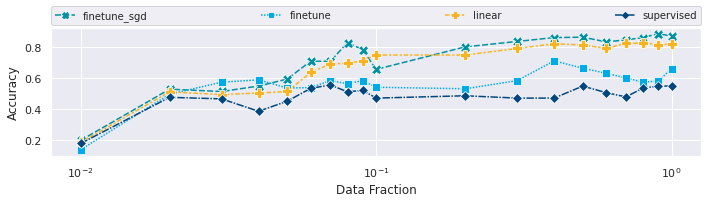

In [23]:
fig, ax = plt.subplots(figsize=(10,3))
sns.lineplot(x="Data Fraction", y="Accuracy/Testing", hue="Model", style="Model", data=multi_label_df, ax=ax, palette=hereon_color_array,  markers=True, markersize=10,)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:])
ax.set_xscale("log")
ax.set_ylabel("Accuracy")
ax.legend(handles[1:], labels[1:], bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
          ncol=4, mode="expand", borderaxespad=0., fontsize=10)
plt.tight_layout()
plt.savefig("Accuracies_Testing_Multilabel.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x="Data Fraction", y="ECE", hue="Model", style="Model", data=multi_label_df, ax=ax, palette=hereon_color_array,  markers=True, markersize=10,)

for item in data_splits_per_experiment:
    ax.text(item,0.2,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:])
ax.set_xscale("log")
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
          ncol=2, mode="expand", borderaxespad=0., fontsize=10)
plt.tight_layout()
plt.savefig("ECE_Testing_Multilabel.png", dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x="Data Fraction", y="loss/Testing", hue="Model", style="Model", data=multi_label_df, ax=ax, palette=hereon_color_array,  markers=True, markersize=10,)

for item in data_splits_per_experiment:
    ax.text(item,2,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:])
ax.set_xscale("log")
ax.legend(loc="best")
plt.savefig("KLDiv_Testing_Multilabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


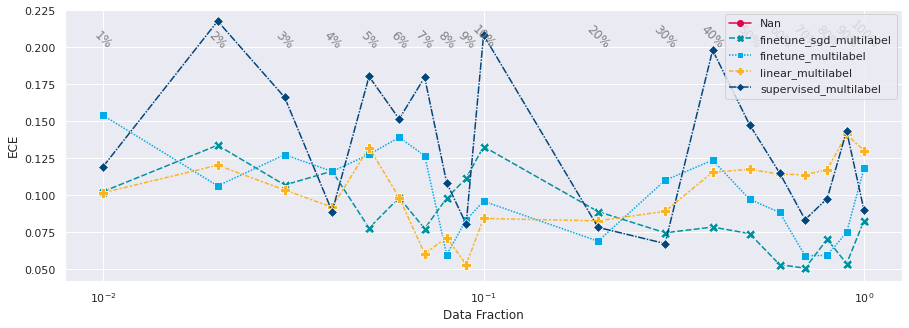

In [75]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x="Data Fraction", y="ECE", hue="Model", style="Model", data=multi_label_df, ax=ax, palette=hereon_color_array,  markers=True, markersize=10,)

for item in data_splits_per_experiment:
    ax.text(item,0.2,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:])
ax.set_xscale("log")
ax.legend(loc="best")
plt.savefig("ECE_Testing_Multilabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


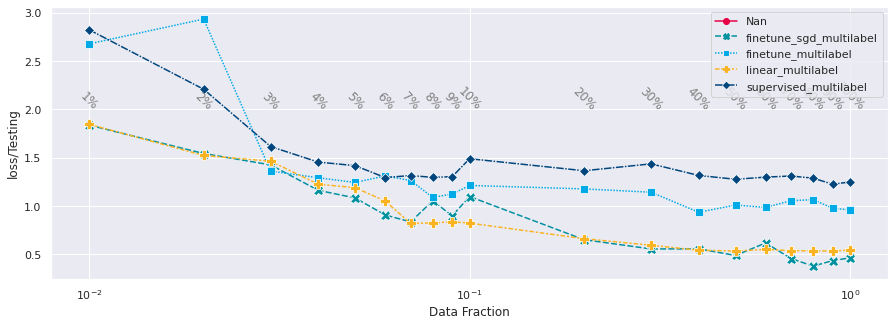

In [76]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x="Data Fraction", y="loss/Testing", hue="Model", style="Model", data=multi_label_df, ax=ax, palette=hereon_color_array,  markers=True, markersize=10,)

for item in data_splits_per_experiment:
    ax.text(item,2,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:])
ax.set_xscale("log")
ax.legend(loc="best")
plt.savefig("KLDiv_Testing_Multilabel.png", dpi=300)

# Single Label

In [9]:
pl.seed_everything(7)
np.random.seed(7)
cfg = hydra.compose(config_name="config", overrides=["+experiment=plankton/publication/supervised_singlelabel", 
                                                     "random_seed=7", 
                                                     "strategy=SingleDevice", 
                                                     'strategy.device="cuda:0"', 
                                                     "trainer.enable_progress_bar=false",
                                                     "datamodule.batch_size=200",
                                                     "lightning_module.log_confusion_matrices=false",
                                                     "lightning_module.temperature_scale=false",
                                                    ])

Global seed set to 7


In [10]:

train_transforms = hydra.utils.instantiate(cfg.datamodule.train_transforms)
valid_transforms = hydra.utils.instantiate(cfg.datamodule.valid_transforms)

datamodule = hydra.utils.instantiate(
    cfg.datamodule,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
    dataset=cfg.datamodule.dataset,
    is_ddp=False,
)
datamodule.setup(stage="test")

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:95: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
77it [00:00, 4368.30it/s]                                                      | 0/19 [00:00<?, ?it/s]
4536it [00:00, 7599.62it/s]
88it [00:00, 3720.00it/s]█▎                                            | 2/19 [00:00<00:05,  3.23it/s]
100it [00:00, 4362.16it/s]
95it [00:00, 4930.45it/s]
288it [00:00, 6502.45it/s]
12it [00:00, 4121.15it/s]███████████▊                                  | 6/19 [00:00<00:01,  9.72it/s]
158it [00:00, 7012.55it/s]
59it [00:00, 6970.23it/s]
1215it [00:00, 10737.09it/s]
386it [00:00, 11836.02it/s]███████████████████▊                       | 10/19 [00:00<00:00, 14.30it/s]
56it [00:00, 6301.98it/s]
1290it [00:00, 11311.97it/s]
207it [00:00, 6932.73it/s]████████████████████████████▌               | 13/19 [00:01

In [11]:
def get_confidence_and_acc_single(logits, labels, acc_func=None, n_bins=20, logits_are_probs=False):
    ece = torch.zeros(1, device=logits.device)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    if not logits_are_probs:
        softmaxes = F.softmax(logits, dim=1)
    else:
        softmaxes = logits
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(labels)
    accuracy_bins = []
    confidence_bins = []
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            accuracy_bins.append(accuracy_in_bin)
            confidence_bins.append(avg_confidence_in_bin)
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return torch.tensor(accuracy_bins), torch.tensor(confidence_bins), ece.item()

In [12]:
def run_and_save(_best_checkpoint, _dataloader, _return_metrics, _key, _experiment_number):
    model = instantiate_model(_best_checkpoint)
    model.log_confusion_matrices = False
    model.temperature_scale = False
    _return_metrics[_key][_experiment_number] = trainer.test(model, _dataloader)[0]
    _return_metrics[_key][_experiment_number]["Data Fraction"] = data_splits_per_experiment[_experiment_number]
    _logits = torch.empty(size=(len(_dataloader.dataset), len(datamodule.unique_labels))).to("cuda:0")
    _labels = torch.empty(size=[len(_dataloader.dataset)]).to("cuda:0")

    with torch.no_grad():
        start = 0
        for i, batch in tqdm(enumerate(_dataloader), total=(len(_dataloader))):
            x, batch_labels = batch
            end = start + len(batch_labels[0])
            _labels[start: end] = batch_labels[0].squeeze()
            _logits[start: end, :] = model(x)[1]

            start = end

    _labels = _labels.detach().cpu().int()
    _logits = _logits.detach().cpu()

    torch.save(_logits, f"test_results/logits_{_key}_{_experiment_number}.pt")
    torch.save(_labels, f"test_results/labels_{_key}_{_experiment_number}.pt")
    with open(f"test_results/dict_{_key}_{_experiment_number}.pkl", 'wb') as f:
        pickle.dump(_return_metrics, f)
    return _logits, _labels, _return_metrics

In [13]:
def return_if_file_exists(func):
    def function_wrapper(*args, **kwargs):
        return func

    file = function_wrapper()
    if os.path.isfile:
        return func
    else:
        raise FileNotFoundError(f"File {file} does not exist")


@return_if_file_exists
def get_temperature_file(checkpoint_file):
    if os.path.split(checkpoint_file)[-1] == "last.ckpt":
        path = os.path.split(checkpoint_file)[0]
        temp_files = natsorted(glob.glob(os.path.join(path, "temperatures_*.tensor")))
        return temp_files[-1]
    else:
        return checkpoint_file.replace("epoch=", "temperatures_").replace(".ckpt", ".tensor")

@return_if_file_exists
def get_distribution_file(checkpoint_file):
    path = os.path.split(checkpoint_file)[0]
    return os.path.join(path, "training_label_distribution.pt")



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


  0%|          | 0/19 [00:00<?, ?it/s]

0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 200. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 174. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │   0.012813003733754158    │
│       loss/Testing        │     36.21129608154297     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/205 [00:00<?, ?it/s]

UnboundLocalError: local variable 'logits' referenced before assignment

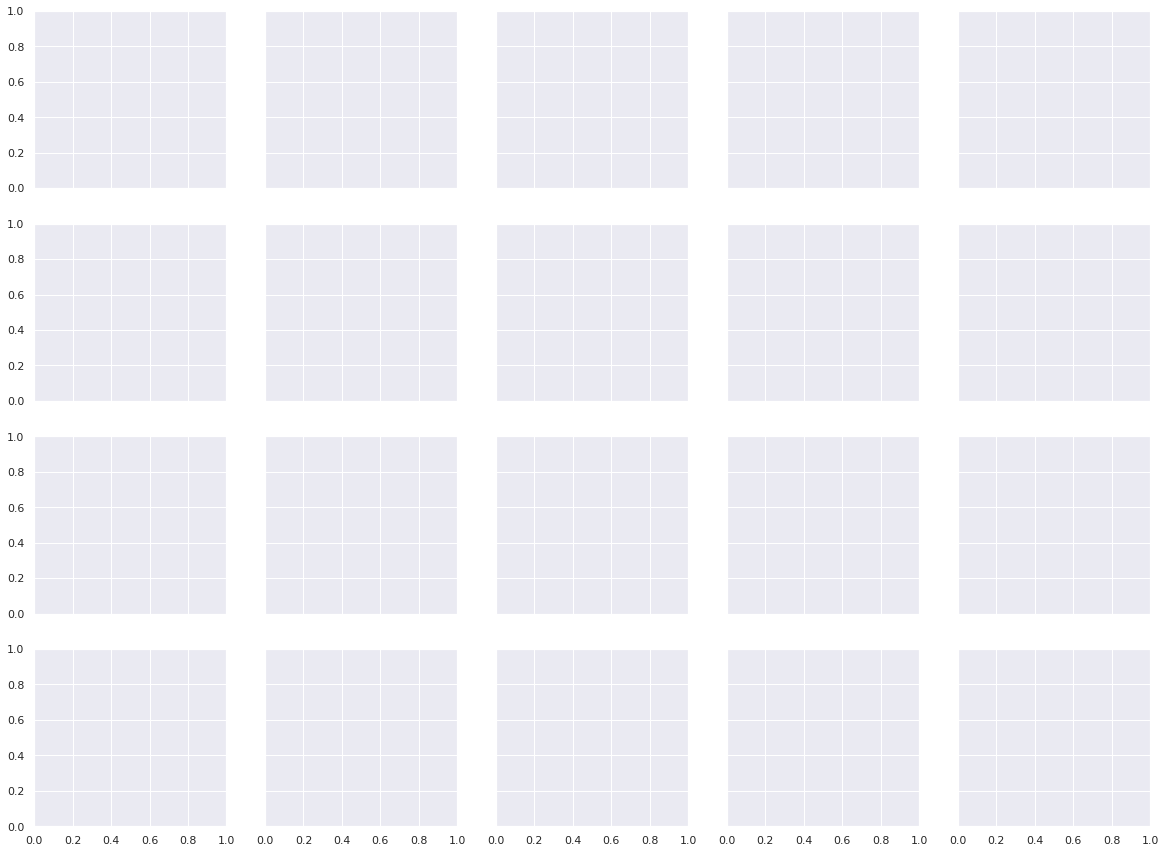

In [16]:
trainer = instantiate_trainer()
    
test_dataloader = datamodule.test_dataloader()
for example_input, _ in test_dataloader:
    break

acc_func = torchmetrics.Accuracy(average="none", num_classes=len(datamodule.unique_labels))
    
return_metrics = dict()
for key, setup_path in experiments_singlelabel.items():
    experiment_folders = [os.path.join(setup_path, str(i)) for i in np.arange(0, 19)]
    return_metrics[key] = dict()
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20,15), sharex=True, sharey=True)
    for experiment_number, experiment_path in enumerate(tqdm(experiment_folders)):
        print(experiment_number)
        with open(os.path.join(experiment_path, "main.log"), "r") as f:
            complete_log = f.readlines()
            found_best_checkpoint = False
            for line in complete_log:
                # print(line)
                if found_best_checkpoint:
                    best_checkpoint = line.strip()
                    # print(f"set best checkpoint to {best_checkpoint}")
                    break
                    
                if "[main.main][INFO] - Best checkpoint path:" in line:
                    found_best_checkpoint = True
                    # print(f"found best checkpoint: {line}")
        if os.path.isfile(f"test_results/labels_{key}_{experiment_number}.pt"):
            print(f"loading {key}_{experiment_number} from file")
            logits = torch.load(f"test_results/logits_{key}_{experiment_number}.pt")
            labels = torch.load(f"test_results/labels_{key}_{experiment_number}.pt")
            with open(f"test_results/dict_{key}_{experiment_number}.pkl", 'rb') as f:
                return_metrics = pickle.load(f)
        else:
            logits, labels, return_metrics = run_and_save(best_checkpoint, test_dataloader, return_metrics, key, experiment_number)

        accuracies, confidences, ece = get_confidence_and_acc_single(logits, labels, acc_func=acc_func)
        return_metrics[key][experiment_number]["ECE"] = ece

        prob_scaling = EvalWrapper(temperature_file=get_temperature_file(best_checkpoint),
                                   training_distribution_file=get_distribution_file(best_checkpoint),
                                   device="cpu")

        corrected_probabilities = prob_scaling(logits=logits, correct_probabilities_with_training_prior=True)
        accuracies_corrected, confidences_corrected, ece_corrected = get_confidence_and_acc_single(corrected_probabilities,
                                                                                                   labels,
                                                                                                   acc_func=acc_func,
                                                                                                   logits_are_probs=True)
        temp_scaled_logits = prob_scaling(logits=logits, correct_probabilities_with_temperature=True)
        accuracies_temp, confidences_temp, ece_temp = get_confidence_and_acc_single(temp_scaled_logits,
                                                                                    labels,
                                                                                    acc_func=acc_func,
                                                                                    logits_are_probs=False)
        temp_and_prior_corrected_probabilities = prob_scaling(logits=temp_scaled_logits,
                                                              correct_probabilities_with_training_prior=True)
        accuracies_temp_and_corrected, confidences_temp_and_corrected, ece_temp_and_corrected = get_confidence_and_acc_single(temp_and_prior_corrected_probabilities, labels, acc_func=acc_func, logits_are_probs=False)

        ax = axes.flatten()[experiment_number]
        sns.lineplot(x=confidences.cpu().numpy(), y=accuracies.cpu().numpy(), ax=ax, label="pure NN outputs")
        sns.lineplot(x=confidences_corrected.cpu().numpy(), y=accuracies_corrected.cpu().numpy(), ax=ax, label="prior corrected outputs")
        sns.lineplot(x=confidences_temp.cpu().numpy(), y=accuracies_temp.cpu().numpy(), ax=ax, label="temp scaled outputs")
        sns.lineplot(x=confidences_temp_and_corrected.cpu().numpy(), y=accuracies_temp_and_corrected.cpu().numpy(), ax=ax, label="temp scaled and corrected")
        ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), c="grey", ls="--")
        ax.set_xlabel("Confidence")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"{key} | {data_splits_per_experiment[experiment_number]}")
        ax.legend(loc="best")
    plt.savefig(f"ConfidenceAccuracy{key}.png", dpi=300)
    plt.show()
    plt.close("all")
    

In [ ]:

datamodule.setup(stage="fit")
val_dataloader = datamodule.val_dataloader()

for batch in val_dataloader:
    example_input, _ = batch
    break

val_logits, val_labels, val_return_metrics = run_and_save(best_checkpoint, val_dataloader, return_metrics, key+"valid", experiment_number)

In [ ]:

datamodule.setup(stage="test")
test_dataloader = datamodule.test_dataloader()

for batch in test_dataloader:
    example_input, _ = batch
    break

test_logits, test_labels, test_return_metrics = run_and_save(best_checkpoint, test_dataloader, return_metrics, key+"test_new", experiment_number)

In [ ]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in return_metrics.items() for innerKey, values in innerDict.items()}
single_label_df = pd.DataFrame.from_dict(reform).T
single_label_df.index.names = ("Model", "Experiment")
single_label_df

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x="Data Fraction", y="Accuracy/Testing", hue="Model", style="Model", data=single_label_df, ax=ax, palette=hereon_color_array,  markers=True, markersize=10,)

# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
plt.savefig("Accuracies_Testing_Singlelabel.png", dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x="Data Fraction", y="ECE", hue="Model", style="Model", data=single_label_df, ax=ax, palette=hereon_color_array,  markers=True, markersize=10,)

for item in data_splits_per_experiment:
    ax.text(item,0.2,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.legend(loc="best")
plt.savefig("ECE_Testing_Singlelabel.png", dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x="Data Fraction", y="loss/Testing", hue="Model", style="Model", data=single_label_df, ax=ax, palette=hereon_color_array,  markers=True, markersize=10,)

for item in data_splits_per_experiment:
    ax.text(item,2,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.legend(loc="best")
plt.savefig("NLL_Testing_Singlelabel.png", dpi=300)